In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append("../")

In [3]:
from queue import Queue
openPMDBuffer = Queue(8)

In [4]:
from ks_producer_openPMD_streaming import StreamLoader
from ks_transform_policies import AbsoluteSquare, BoxesAttributesParticles

normalization_values = dict(
    momentum_mean = 1.2091940752668797e-08,
    momentum_std = 0.11923234769525472,
    force_mean = -2.7682006649827533e-09,
    force_std = 7.705477610810592e-05
)

streamLoader_config = dict(
    t0 = 900,
    t1 = 1001,
    # t0 =  1800,
    # t1 = 1810,
    streaming_config = None,
    pathpattern1 = "/bigdata/hplsim/production/KHI_for_GB_MR/runs/014_KHI_007_noWindowFunction/simOutput/openPMD/simData_%T.bp", # files on hemera
    pathpattern2 = "/bigdata/hplsim/production/KHI_for_GB_MR/runs/014_KHI_007_noWindowFunction/simOutput/radiationOpenPMD/e_radAmplitudes%T.bp", # files on hemera
    # pathpattern1 = "/bigdata/hplsim/production/KHI_for_GB_MR/runs/008_KHI_rad4dir_smallY_highRes/simOutput/openPMD/simData_%T.bp", # files on hemera
    # pathpattern2 = "/bigdata/hplsim/production/KHI_for_GB_MR/runs/008_KHI_rad4dir_smallY_highRes/simOutput/radiationOpenPMD/e_radAmplitudes%T.bp", # files on hemera
    amplitude_direction=0, # choose single direction along which the radiation signal is observed, max: N_observer-1, where N_observer is defined in PIConGPU's radiation plugin
    phase_space_variables = ["momentum", "force"], # allowed are "position", "momentum", and "force". If "force" is set, "momentum" needs to be set too.
    number_particles_per_gpu = 30000,
    verbose=False,
    ## offline training params
    num_epochs = .01, #.0625
    normalization = normalization_values
)

timeBatchLoader = StreamLoader(openPMDBuffer, 
                                        streamLoader_config,
                                        BoxesAttributesParticles(), AbsoluteSquare())

timeBatchLoader.start()

In [5]:
openPMDBuffer.qsize()

[WARNING] No chunk table found in data. Will map source to sink ranks somehow, but this might scale terribly in streaming setups.
[Series] Use rank table in file-based iteration encoding at your own risk. Make sure to have an iteration open before calling this.


0

In [6]:
t = openPMDBuffer.get()

Start processing iteration 900
particles per GPU 30000
Done loading iteration 900


Start processing iteration 901
particles per GPU 30000


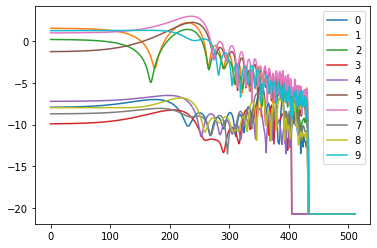

In [7]:
for i in range(10):
    plt.plot(t[1][i], label=str(i))
plt.legend()
#plt.xlim(400,430)

In [25]:
#ckptfn = "/home/kelling/checkout/FWKT/InSituML/main/ModelHelpers/cINN/slurm-6921762/model_8081"
#ckptfn = "/home/kelling/checkout/FWKT/InSituML/main/ModelHelpers/cINN/slurm-6921753/model_809"
chkptfn = "/home/kelling/checkout/FWKT/InSituML/main/ModelHelpers/cINN/runs_y/slurm-6921781/model_19000"
chkptfn = "/home/kelling/checkout/FWKT/InSituML/main/ModelHelpers/cINN/runs_y/slurm-6921781/model_19000"
#ckptfn = "/home/kelling/checkout/FWKT/InSituML/main/ModelHelpers/cINN/slurm-6921842/model_8081"
#ckptfn = "/home/kelling/checkout/FWKT/InSituML/main/ModelHelpers/cINN/trained_models/inn_vae_latent_544_sim014_859eopan/model_950"
#ckptfn = "/home/kelling/checkout/FWKT/InSituML/main/ModelHelpers/cINN/runs014_30k/slurm-{}/model_{}"
#ckptfn = chkptfn.format(6921756, 809) # 950, contniue at 150k
#ckptfn = chkptfn.format(6921771, 8081) # 950, tuned at 30k
chkptfn = "/home/kelling/checkout/FWKT/InSituML/main/ModelHelpers/cINN/slurm-{}/model_{}"
#chkptfn = chkptfn.format(6923061, 800) # 150, tuned at 30k, continual_bs=4, buffersize=5,training_bs=4, offline
#chkptfn = chkptfn.format(6923062, 800) # 150, tuned at 30k, continual_bs=0, buffersize=4,training_bs=4, offline
#chkptfn = chkptfn.format(6923051, 1600) # 950, tuned at 30k, Y, continual_bs=4, buffersize=5,training_bs=4, offline
#chkptfn = chkptfn.format(6923053, 2000) # 950, tuned at 30k, continual_bs=4, buffersize=5,training_bs=4, offline
chkptfn = chkptfn.format(6923281, 800) # None, continual_bs=4, buffersize=5,training_bs=4, offline

print(chkptfn)

ckpt = torch.load(chkptfn)

import model_config
import io_config_hemera as io_config

config = model_config.config

import torch.nn as nn
from torch import optim

from ks_models import INNModel

from utilities import MMD_multiscale, fit, load_checkpoint
from train_khi_AE_refactored.args_transform import MAPPING_TO_LOSS
from train_khi_AE_refactored.encoder_decoder import Encoder
from train_khi_AE_refactored.encoder_decoder import Encoder
from train_khi_AE_refactored.encoder_decoder import Conv3DDecoder, MLPDecoder
from train_khi_AE_refactored.loss_functions import EarthMoversLoss
from train_khi_AE_refactored.networks import VAE, ConvAutoencoder

world_size = 1

class ModelFinal(nn.Module):
    def __init__(self,
                base_network,
                inner_model,
                loss_function_IM = None,
                weight_AE=1.0,
                weight_IM=1.0):
        super().__init__()

        self.base_network = base_network
        self.inner_model = inner_model
        self.loss_function_IM = loss_function_IM
        self.weight_AE = weight_AE
        self.weight_IM = weight_IM

    def forward(self, x, y):

        loss_AE,loss_ae_reconst,kl_loss, _, encoded = self.base_network(x)

        # Check if the inner model is an instance of INNModel
        if isinstance(self.inner_model, INNModel):
            # Use the compute_losses function of INNModel
            loss_IM, l_fit,l_latent,l_rev = self.inner_model.compute_losses(encoded, y)
            total_loss = loss_AE*self.weight_AE + loss_IM*self.weight_IM

            losses = {
                'total_loss': total_loss,
                'loss_AE': loss_AE*self.weight_AE,
                'loss_IM': loss_IM*self.weight_IM,
                'loss_ae_reconst': loss_ae_reconst,
                'kl_loss': kl_loss,
                'l_fit': l_fit,
                'l_latent': l_latent,
                'l_rev': l_rev,
                    }

            return losses
        else:
            # For other types of models, such as MAF
            loss_IM = self.inner_model(inputs=encoded, context=y)
            total_loss = loss_AE*self.weight_AE + loss_IM * self.weight_IM

            losses = {
                'total_loss': total_loss,
                'loss_AE': loss_AE*self.weight_AE,
                'loss_IM': loss_IM*self.weight_IM,
                'loss_ae_reconst': loss_ae_reconst,
                'kl_loss': kl_loss
                    }

            return losses

    def reconstruct(self,x, y, num_samples = 1):

        if isinstance(self.inner_model, INNModel):
            lat_z_pred = self.inner_model(x, y, rev = True)
            y = self.base_network.decoder(lat_z_pred)
        else:
            lat_z_pred = self.inner_model.sample_pointcloud(num_samples = num_samples, cond=y)
            y = self.base_network.decoder(lat_z_pred)

        return y, lat_z_pred


VAE_encoder_kwargs = {"ae_config":"non_deterministic",
                "z_dim":model_config.latent_space_dims,
                "input_dim":io_config.ps_dims,
                "conv_layer_config":[16, 32, 64, 128, 256, 608],
                "conv_add_bn": False,
                "fc_layer_config":[544]}

VAE_decoder_kwargs = {"z_dim":model_config.latent_space_dims,
                "input_dim":io_config.ps_dims,
                "initial_conv3d_size":[16, 4, 4, 4],
                "add_batch_normalisation":False,
                    "fc_layer_config":[1024]}
def load_objects(rank):

    torch.cuda.set_device(rank)
    torch.cuda.empty_cache()

    loss_fn_for_VAE = MAPPING_TO_LOSS[model_config.config['loss_function']](**model_config.config['loss_kwargs'])

    VAE_obj = VAE(encoder = Encoder,
            encoder_kwargs = VAE_encoder_kwargs,
            decoder = Conv3DDecoder,
            z_dim=model_config.latent_space_dims,
            decoder_kwargs = VAE_decoder_kwargs,
            loss_function = loss_fn_for_VAE,
            property_="momentum_force",
            particles_to_sample = io_config.number_of_particles,
            ae_config="non_deterministic",
            use_encoding_in_decoder=False,
            weight_kl=model_config.config["lambd_kl"],
            device=rank)

    # conv_AE
#     conv_AE_encoder_kwargs = {"ae_config":"simple",
#                     "z_dim":model_config.latent_space_dims,
#                     "input_dim":io_config.ps_dims,
#                     "conv_layer_config":[16, 32, 64, 128, 256, 512],
#                     "conv_add_bn": False}

#     conv_AE_decoder_kwargs = {"z_dim":model_config.latent_space_dims,
#                     "input_dim":io_config.ps_dims,
#                     "add_batch_normalisation":False}

#     conv_AE = ConvAutoencoder(encoder = Encoder,
#                             encoder_kwargs = conv_AE_encoder_kwargs,
#                             decoder = Conv3DDecoder,
#                             decoder_kwargs = conv_AE_decoder_kwargs,
#                             loss_function = EarthMoversLoss(),
#                             )

    # MAF inner model (not used in final runs)
    # inner_model = PC_MAF(dim_condition=config["dim_condition"],
    #                         dim_input=config["dim_input"],
    #                         num_coupling_layers=config["num_coupling_layers"],
    #                         hidden_size=config["hidden_size"],
    #                         device=rank,
    #                         num_blocks_mat = config["num_blocks_mat"],
    #                         activation = config["activation"]
    #                         )

    # INN
    inner_model = INNModel(ndim_tot=config["ndim_tot"],
                    ndim_x=config["ndim_x"],
                    ndim_y=config["ndim_y"],
                    ndim_z=config["ndim_z"],
                    loss_fit=fit,
                    loss_latent=MMD_multiscale,
                    loss_backward=MMD_multiscale,
                    lambd_predict=config["lambd_predict"],
                    lambd_latent=config["lambd_latent"],
                    lambd_rev=config["lambd_rev"],
                    zeros_noise_scale=config["zeros_noise_scale"],
                    y_noise_scale=config["y_noise_scale"],
                    hidden_size=config["hidden_size"],
                    activation=config["activation"],
                    num_coupling_layers=config["num_coupling_layers"],
                    device = rank)

    #model = ModelFinal(VAE_obj, inner_model, EarthMoversLoss())
    #model = ModelFinal(conv_AE, inner_model, EarthMoversLoss())
    model = ModelFinal(VAE_obj,
                       inner_model,
                       EarthMoversLoss(),
                       weight_AE=config["lambd_AE"],
                       weight_IM=config["lambd_IM"])


    #Load a pre-trained model
    # filepath = '/autofs/nccs-svm1_home1/ksteinig/src/InSituML/main/ModelHelpers/cINN/trained_models/{}/best_model_'
    # filepath = 'trained_models/{}/best_model_'
    filepath = io_config.modelPathPattern

    #map_location = {'cuda:%d' % 0: 'cuda:%d' % rank}
    
    # updated_state_dict = {key.replace('VAE.', 'base_network.'): value for key, value in original_state_dict.items()}
    updated_state_dict = {key.replace('module.', ''): value for key, value in ckpt["model"].items()}
    model.load_state_dict(updated_state_dict)

    lr = config["lr"]
    bs_factor = io_config.trainBatchBuffer_config["training_bs"] / 2 * world_size
    lr = lr * config["lr_scaling"](bs_factor)
    print("Skaling learning rate from {} to {} due to bs factor {}".format(config["lr"], lr, bs_factor))
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=config["betas"],
                         eps=config["eps"], weight_decay=config["weight_decay"])
    if ( "lr_annealingRate" not in config ) or config["lr_annealingRate"] is None:
        scheduler = None
    else:
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=config["lr_annealingRate"])

    return optimizer, scheduler, model



/home/kelling/checkout/FWKT/InSituML/main/ModelHelpers/cINN/slurm-6923281/model_800


In [21]:
opt, sched, model = load_objects(0)
model.cuda()

Skaling learning rate from 0.001 to 0.0014142135623730952 due to bs factor 2.0


ModelFinal(
  (base_network): VAE(
    (loss_function): EarthMoversLoss()
    (encoder): Encoder(
      (layers): Sequential(
        (0): Conv1d(6, 16, kernel_size=(1,), stride=(1,))
        (1): ReLU()
        (2): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
        (3): ReLU()
        (4): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
        (5): ReLU()
        (6): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
        (7): ReLU()
        (8): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
        (9): ReLU()
        (10): Conv1d(256, 608, kernel_size=(1,), stride=(1,))
        (11): ReLU()
        (12): AdaptiveMaxPool1d(output_size=1)
        (13): Flatten(start_dim=1, end_dim=-1)
      )
      (mean): Sequential(
        (0): Linear(in_features=608, out_features=544, bias=True)
        (1): BatchNorm1d(544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Linear(in_features=544, out_features=544, bias=True)
      )
      (varia

In [22]:
def plot(boxList, xlim=(-3,3), ylim=(-.4,.4)):
    plt.rcParams.update({'font.size': 30})
    x = t[0][boxList]
    y = t[1][boxList]
    dec = model.base_network.forward(x.transpose(1,2).cuda())
    decoded = dec[3].detach().cpu()
    pc_pr = []
    lat_z_pred = []
    for i in range(4):
        p, l = model.reconstruct(x.cuda(), y.cuda())
        pc_pr.append(p.detach().cpu().numpy())

    for bi in range(len(boxList)):

        fig, ax = plt.subplots(1, 2+len(pc_pr), figsize=(10*(2+len(p)), 10), sharey=True, squeeze=True)
        for i, p in enumerate(pc_pr):
            ax[2+i].hexbin(p[bi,:,0], p[bi,:,1], bins="log")
            ax[2+i].set(xlim=xlim, ylim=ylim, title="INN bw sample")
        ax[0].hexbin(x[bi,0,:].numpy(), x[bi,1,:].numpy(), bins="log")
        ax[0].set(xlim=xlim, ylim=ylim, title="GT")
        ax[1].hexbin(decoded[bi,:,0].numpy(), decoded[bi,:,1].numpy(), bins="log")
        ax[1].set(xlim=xlim, ylim=ylim, title="AE")
        fig.show()


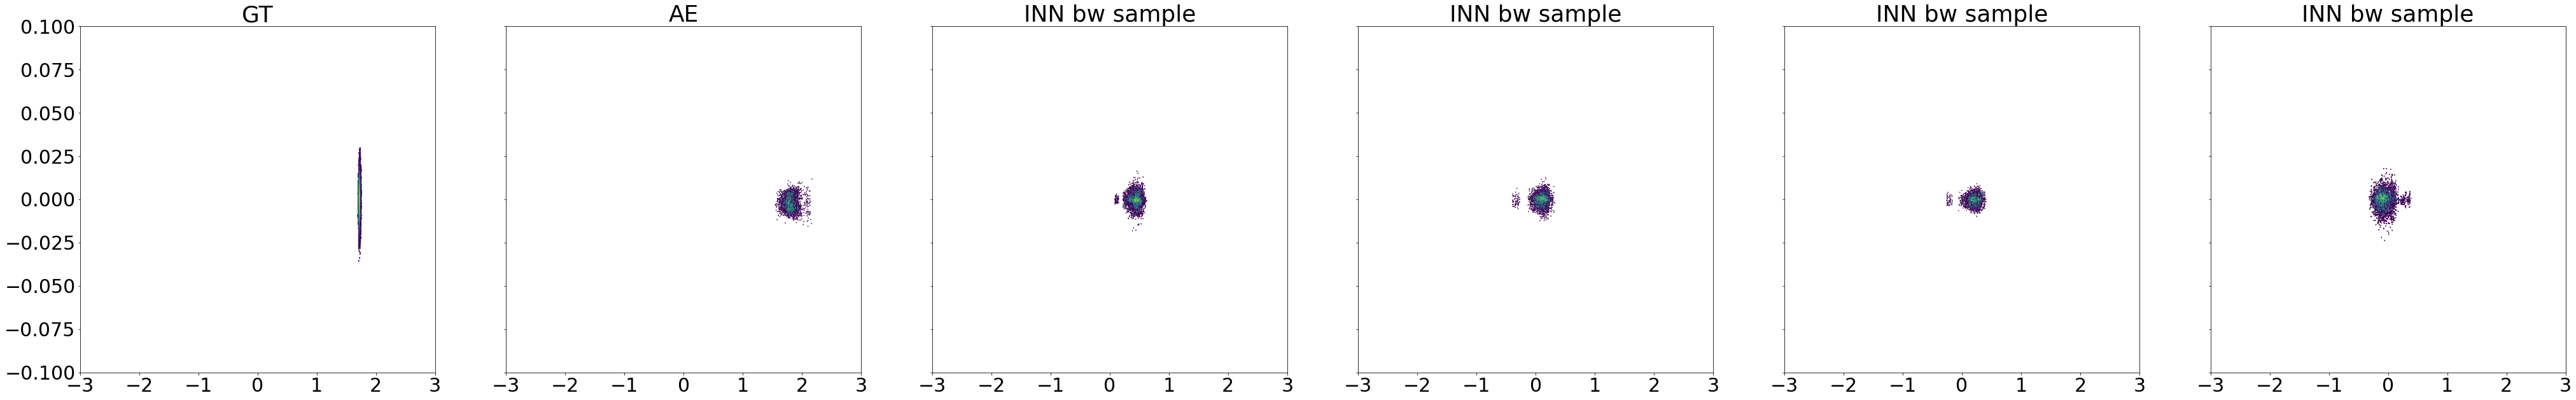

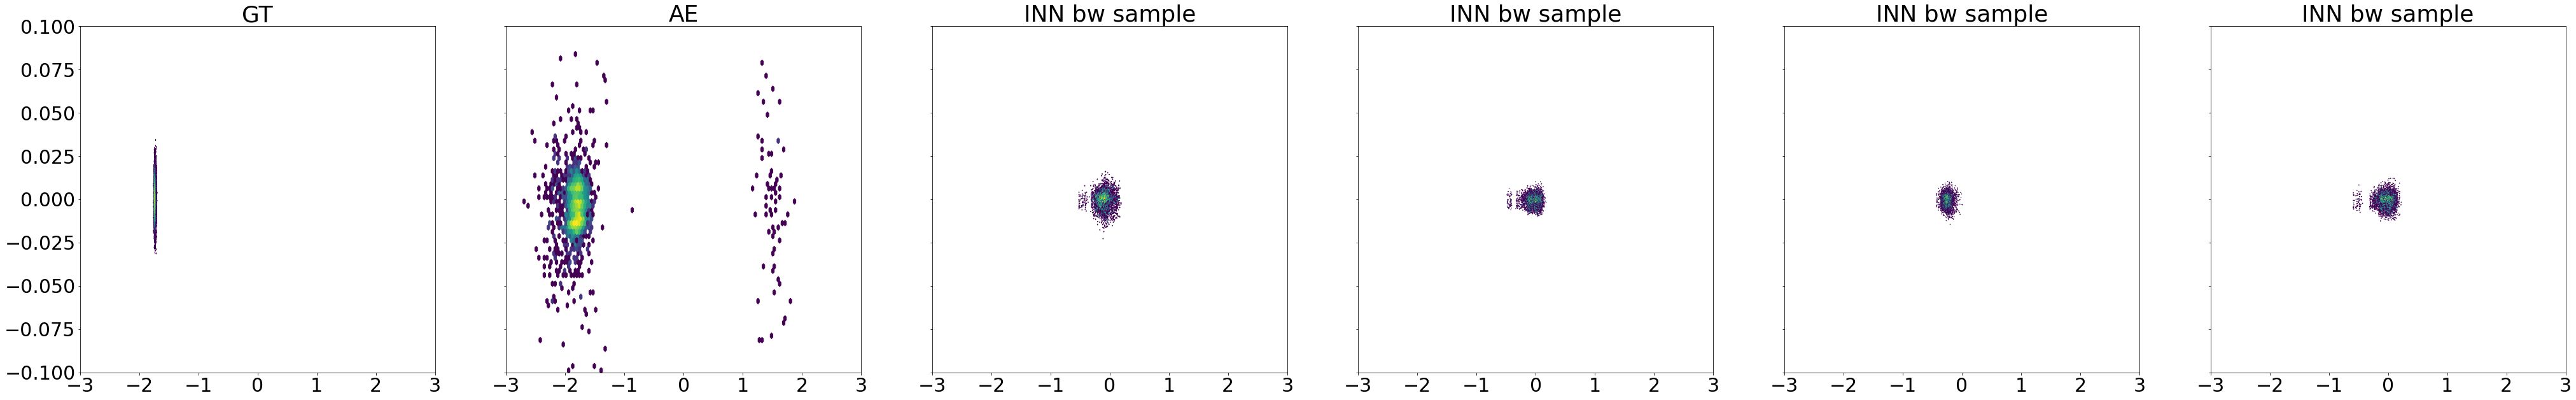

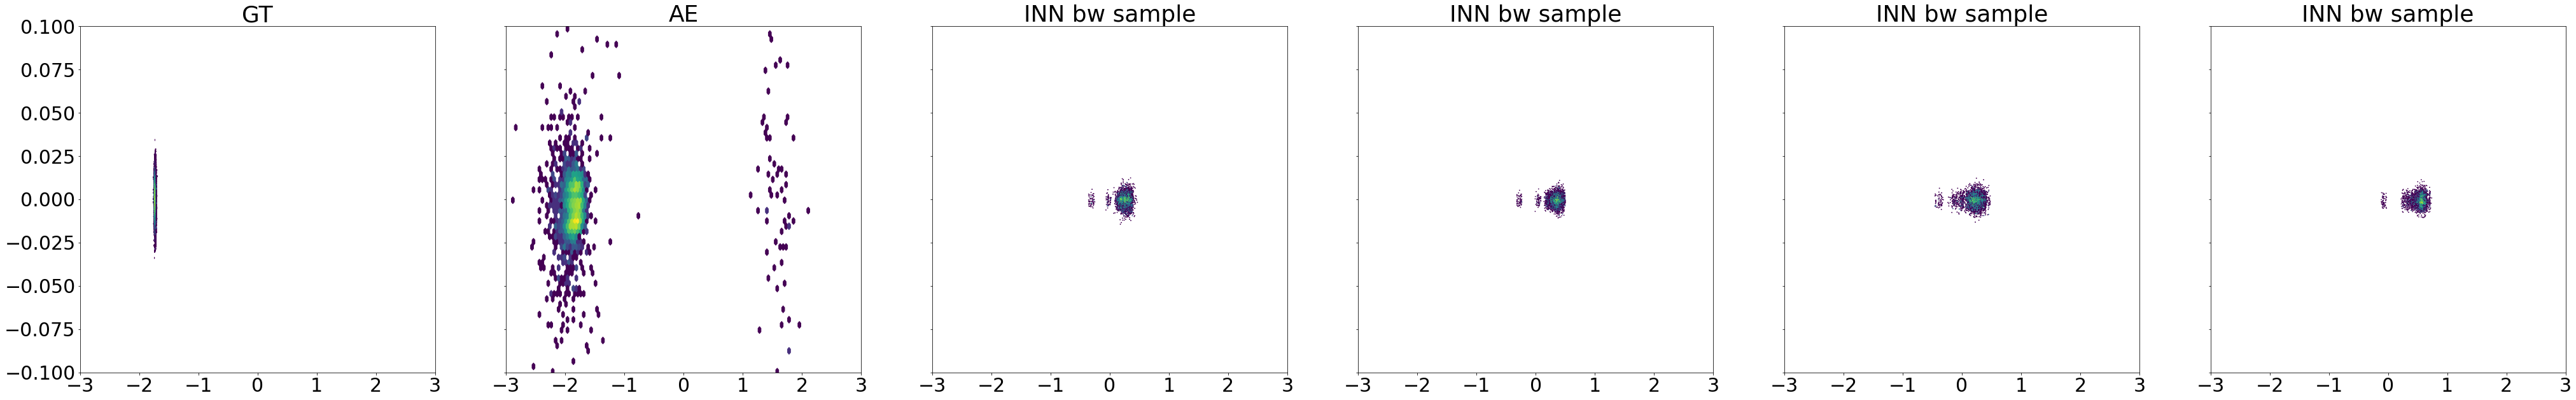

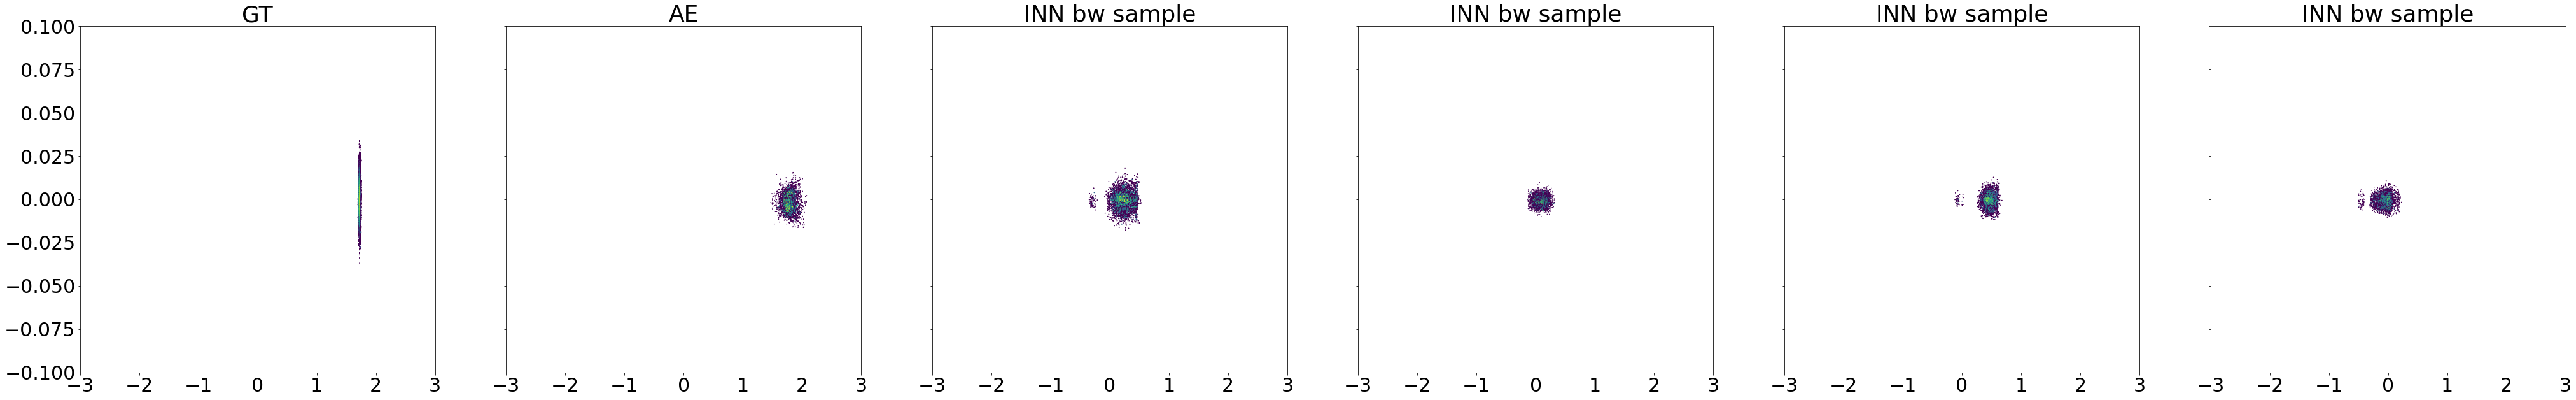

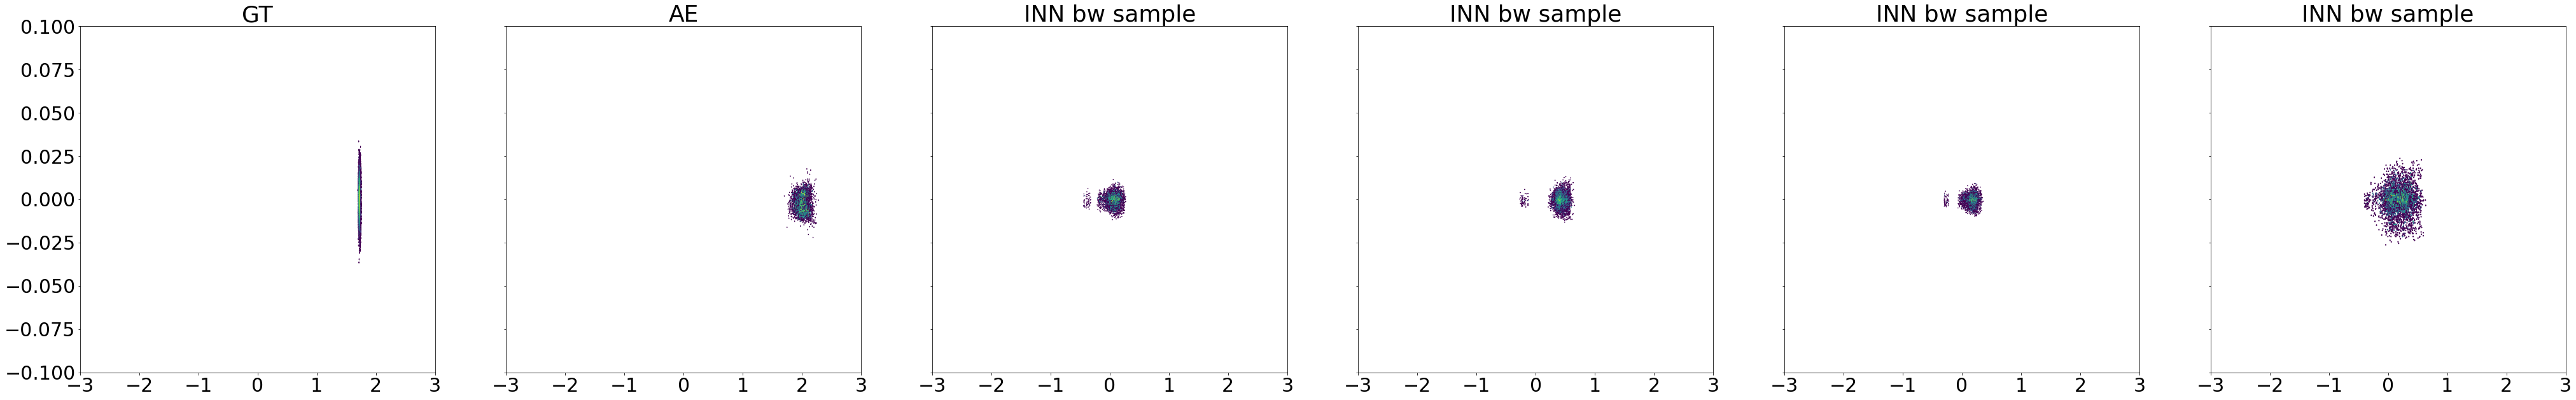

In [23]:
plot(boxList = [0,3,4,7,8], xlim=(-3,3), ylim=(-.1,.1))

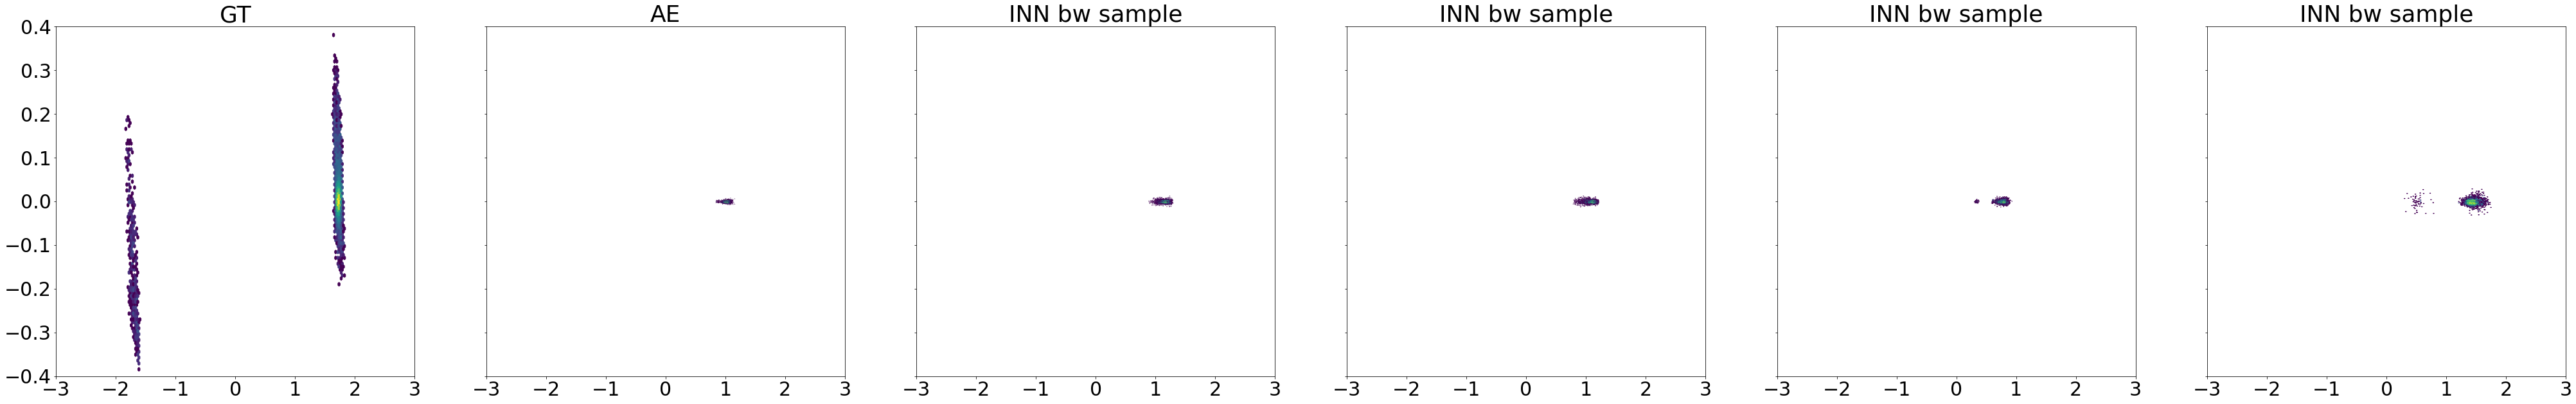

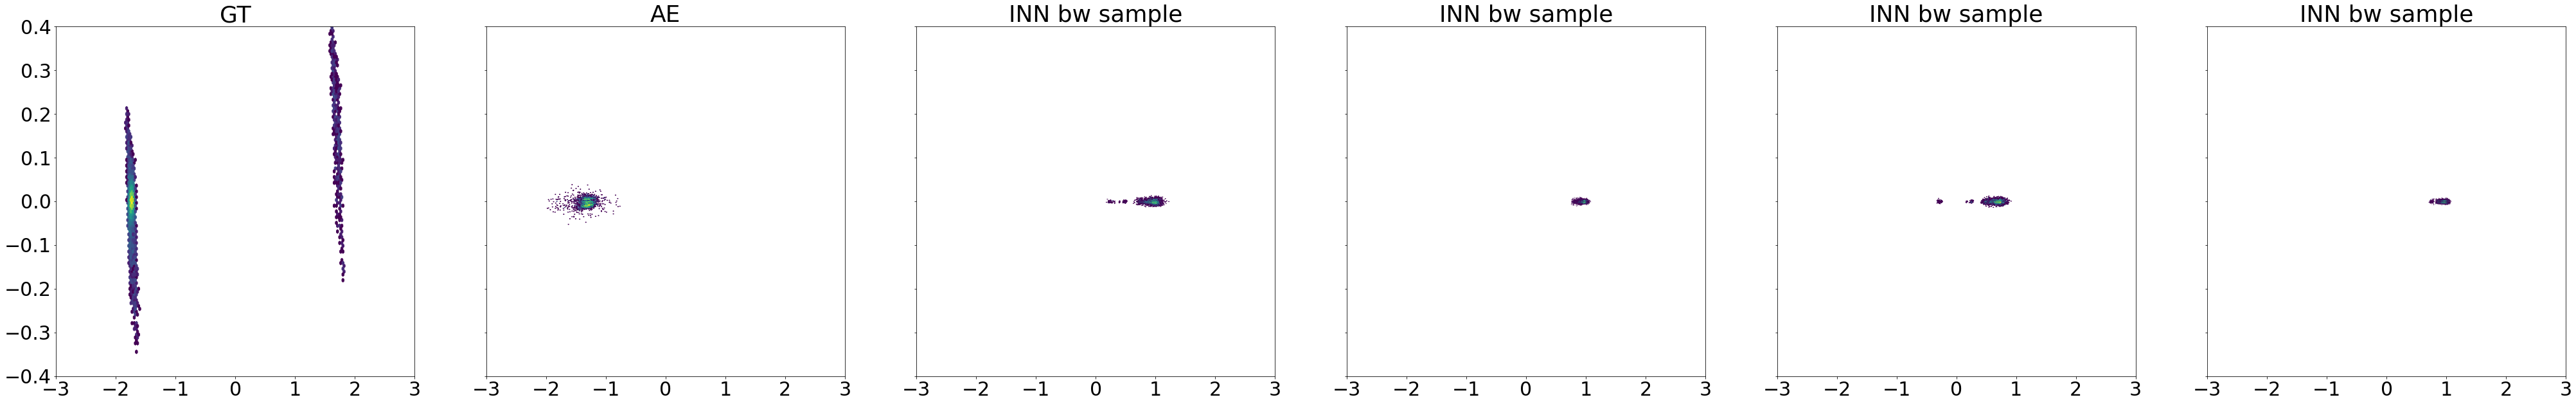

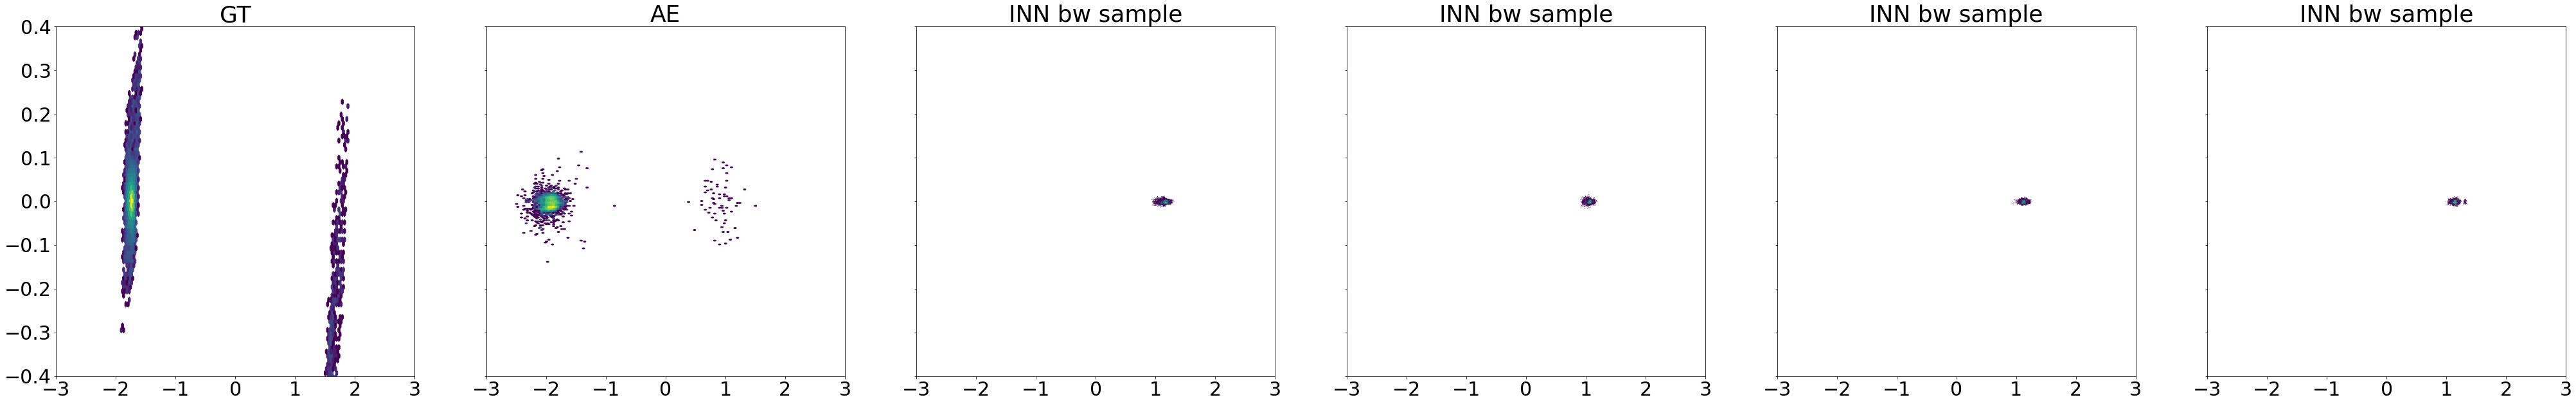

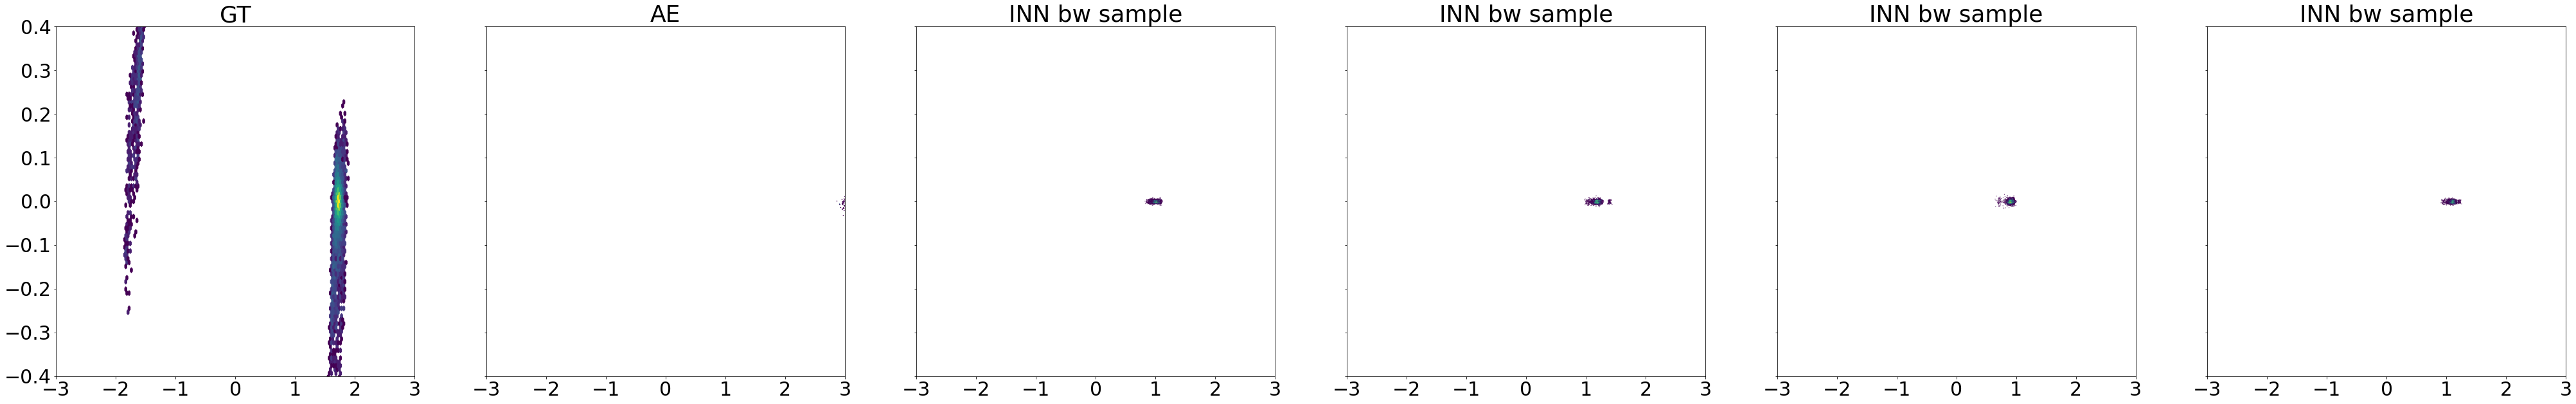

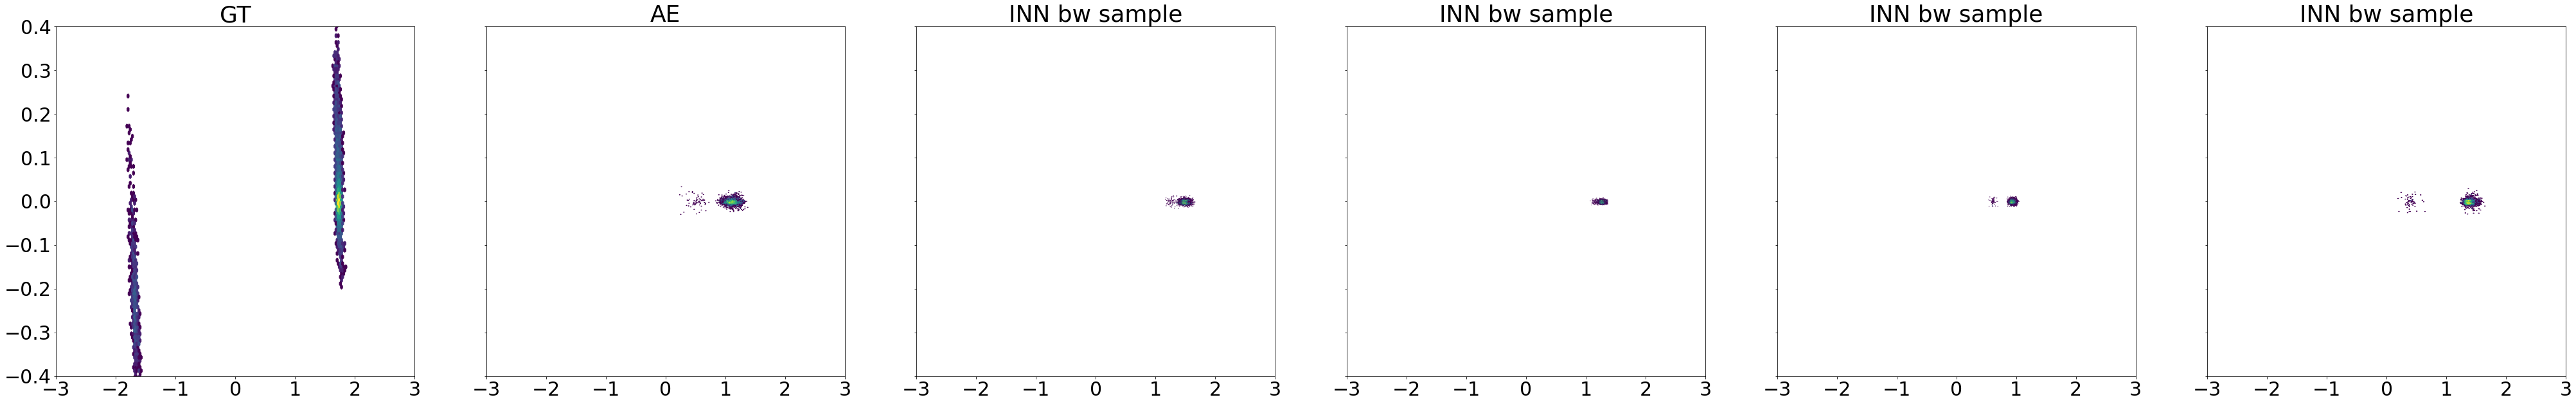

In [24]:
plot(boxList = [1,2,5,6,9])